<a href="https://colab.research.google.com/github/zoegarm/Cancer-de-mama-en-Mexico-analisis/blob/main/Corr_entre_datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Correlación entre artículos publicados y el número de mastografías realizado.

## Esta actualización tiene como objetivo el observar la correlación entre el número de publicaciones con tema cáncer de mama y el índice de atención.

In [301]:
# Importamos las librerias y obtenemos 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn  as sns

sns.set(style='darkgrid')

In [302]:
# Cargamos los DS para cada año

# renombramos los datos en los DF
renombre = {
    'Coahuila de Zaragoza': 'Coahuila',
    'Ciudad de México': 'Distrito Federal',
    'Michoacán de Ocampo': 'Michoacán',
    'Veracruz de Ignacio de la Llave': 'Veracruz',
    'Estado de México': 'México'}

#2013
sicam13_estado = pd.read_csv("https://raw.githubusercontent.com/zoegarm/Cancer-de-mama-en-Mexico-analisis/main/DATA_CLEAN/SICAM/masto_2013_SICAM_estado.csv", index_col=0)
sicam13_estado = sicam13_estado.replace({"estado": renombre})

# 2014
sicam14_estado = pd.read_csv("https://raw.githubusercontent.com/zoegarm/Cancer-de-mama-en-Mexico-analisis/main/DATA_CLEAN/SICAM/masto_2014_SICAM_estado.csv", index_col=0)
sicam14_estado = sicam14_estado.replace({"estado": renombre})

# 2015
sicam15_estado = pd.read_csv("https://raw.githubusercontent.com/zoegarm/Cancer-de-mama-en-Mexico-analisis/main/DATA_CLEAN/SICAM/masto_2015_SICAM_estado.csv", index_col=0)
sicam15_estado = sicam15_estado.replace({"estado": renombre})

# 2016
sicam16_estado = pd.read_csv("https://raw.githubusercontent.com/zoegarm/Cancer-de-mama-en-Mexico-analisis/main/DATA_CLEAN/SICAM/masto_2016_SICAM_estado.csv", index_col=0)
sicam16_estado = sicam16_estado.replace({"estado": renombre})

# 2017
sicam17_estado = pd.read_csv("https://raw.githubusercontent.com/zoegarm/Cancer-de-mama-en-Mexico-analisis/main/DATA_CLEAN/SICAM/masto_2017_SICAM_estado.csv", index_col=0)
sicam17_estado = sicam17_estado.replace({"estado": renombre})

# 2019
sicam19_estado = pd.read_csv("https://raw.githubusercontent.com/zoegarm/Cancer-de-mama-en-Mexico-analisis/main/DATA_CLEAN/SICAM/masto_2019_SICAM_estado.csv", index_col=0)
sicam19_estado = sicam19_estado.replace({"estado": renombre})

# Hacems un DF con todos los datos
masto = sicam13_estado.append([sicam14_estado, sicam15_estado, sicam16_estado, sicam17_estado, sicam19_estado]).reset_index(drop=True)
masto.tail()



# realiamos un DS con el total por año
conteo = {'year': list(range(2013, 2020)), 
          'num_pruebas': [sicam13_estado['count'].sum(), sicam14_estado['count'].sum(), 
                                sicam15_estado['count'].sum(), sicam16_estado['count'].sum(),
                                sicam17_estado['count'].sum(), None, sicam19_estado['count'].sum()]}

conteo = pd.Series(conteo['num_pruebas'], index=conteo['year'])
# conteo['Numero de pruebas'] = conteo['Numero de pruebas']/10e2

conteo

2013    790051.0
2014    816704.0
2015    944800.0
2016    855318.0
2017    855017.0
2018         NaN
2019    790718.0
dtype: float64

In [303]:
#importo mis DS y los junto en un DF

web_scrap = []

for i in range(3,10):
  x = pd.read_csv(f"https://raw.githubusercontent.com/zoegarm/Equipo_2_P2_Analisis/main/DATA_CLEAN/WebScrapping_clean/Scrapping_201{i}_clean.csv", index_col=0)
  web_scrap.append(x)

web_scrap = pd.concat(web_scrap)

#filtro los totales de artículos publicados:
#creo un DF que tenga el conteo total de artículos por mes y año:
web_scrap_count = web_scrap.groupby(['year', 'mes'])[['mes']].agg('count').rename(columns = {'mes':'total_articulos'}).reset_index()
total_articulos = pd.Series(list(web_scrap_count.groupby(['year'])['total_articulos'].agg('sum')), index = [i for i in range(2013, 2020)])
years = pd.Series([i for i in range(2013,2020)])

total_articulos

2013    250
2014    220
2015    297
2016    256
2017    287
2018    294
2019    316
dtype: int64

In [304]:
#cargo el DS de interés de búsqueda en google: 
interes_busqueda = pd.read_csv('https://raw.githubusercontent.com/zoegarm/Equipo_2_P2_Analisis/main/DATA_CLEAN/Indice_Atencion/interes_cancer_de_mama_busqueda_clean.csv', index_col=0)
interes_busqueda['fecha'] = pd.to_datetime(interes_busqueda['fecha'])
interes_busqueda['year'] = list(interes_busqueda.fecha.dt.year)
interes_busqueda['mes'] = list(interes_busqueda.fecha.dt.month)
interes_busqueda = interes_busqueda[interes_busqueda['year']<2020]
interes_agno = pd.Series(interes_busqueda.groupby(['year'])['interes_en_cancer'].agg('sum'), index= [i for i in range(2013, 2020)])

interes_agno

2013    161
2014    221
2015    236
2016    180
2017    222
2018    308
2019    376
Name: interes_en_cancer, dtype: int64

Grafico el logaritmo de los datos para visualizar mejor la imágen: 

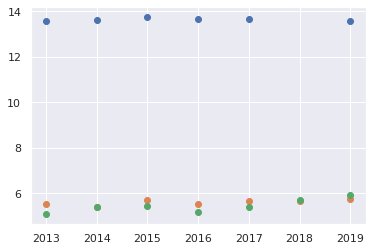

In [305]:
plt.scatter(conteo.index, np.log(conteo))
plt.scatter(total_articulos.index, np.log(total_articulos))
plt.scatter(interes_agno.index, np.log(interes_agno))
# plt.ylim(7e5, 10e5)

In [311]:
df = pd.concat((conteo, total_articulos, interes_agno), axis = 1)
df = df.rename(columns = {0:'conteo', 1: 'articulos', 'interes_en_cancer':'interes'})

In [313]:
#dropeo los datos del 2018 porque no están disponibles para el conteo de mastografías:
df = df.drop(index=[2018]) 

#reviso qué datos son representativos:

Q1 = np.percentile(df.interes, 25, interpolation = 'midpoint') 
Q2 = np.percentile(df.interes, 75, interpolation = 'midpoint') 

print(f'el rango para el interés es: {Q1} - {Q2}')

Q1 = np.percentile(df.articulos, 25, interpolation = 'midpoint') 
Q2 = np.percentile(df.articulos, 75, interpolation = 'midpoint') 

print(f'el rango para el número de articulos es: {Q1} - {Q2}')

Q1 = np.percentile(df.conteo, 25, interpolation = 'midpoint') 
Q2 = np.percentile(df.conteo, 75, interpolation = 'midpoint') 

print(f'el rango para el conteo de mastografías es: {Q1} - {Q2}')

el rango para el interés es: 200.5 - 229.0
el rango para el número de articulos es: 253.0 - 292.0
el rango para el conteo de mastografías es: 803711.0 - 855167.5


Según esta estimación son outliers los datos para los años 2013 y 2019, ya que sus valores salen del rango en más de una categoría.

In [315]:
df = df.drop(index=[2019, 2013])
df.corr()

,conteo,articulos,interes
conteo,1.000000,0.811985,0.420993
articulos,0.811985,1.000000,0.346268
interes,0.420993,0.346268,1.000000


Text(0.5, 1.0, 'Conteo de Mastografías vs N° de Artículos web publicados')

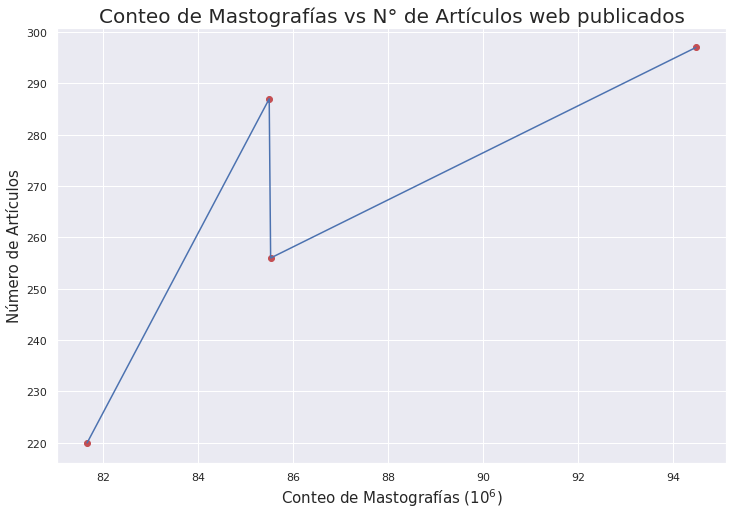

In [334]:
plt.figure(figsize=(12, 8))

df = df.sort_values(by = 'conteo')
plt.scatter(df.conteo, df.articulos, color = 'r')
plt.plot(df.conteo, df.articulos, color = 'b')

plt.xlabel('Conteo de Mastografías ($10^6$)', fontsize = 15)
plt.ylabel('Número de Artículos', fontsize = 15)

plt.xticks(ticks=[820000, 840000, 860000, 880000, 900000, 920000, 940000], labels = ["82", "84", "86", "88", "90", "92", "94"])

plt.title('Conteo de Mastografías vs N° de Artículos web publicados', fontsize = 20)

Aunque la correlación de Pearson para este gráfico es del 0.81 y muestra que hay una relación entre el número de publicaciones web realizadas y el conteo de mastografías, yo no me atravería a decir que esta es una prueba conclusiva de que efectivamente -entre más artículos se publiquen, entonces más personas se realizan tratamientos preventivos-, esto debido al número de datos con el que cuento, ya que no es lo suficientemente extenso. A falta de una prueba que indique lo contrario, por otro lado, me aventuro a decir que puede ser verdadera y que solo podríamos averiguar más si contasemos con una base de datos más extensa, que para nuestra mala suerte no está disponible. Aún así, realizar difusión acerca de un tema de salud como lo es el cáncer de mama es muy importante, ya que sí se ha demostrado que una valoración temprana puede, en la mayoría de los casos, cambiar de manera drástica la forma en la que se combate el cáncer de mama.